## Constructing a Network of Wikipedia Pages

Wikipedia page body has external links and links to other Wikipedia pages. To build a network out of the seed page and other relevant pages, let’s treat
the pages as the network nodes and the links between the pages as the network edges. We will use snowball sampling to discover all the nodes and edges of interest. Our seed page is **"complex network"** .

In [2]:
#the operator itemgetter for sorting a list of tuples
from operator import itemgetter
import networkx as nx
import wikipedia

SEED = "Complex network".title()

# ignore any links to them
STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier", "Pubmed Central",
         "Digital Object Identifier", "Arxiv",
         "Proc Natl Acad Sci Usa", "Bibcode",
         "Library Of Congress Control Number", "Jstor")

In [3]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED)   # The SEED itself
done_set = set()       # Nothing is done yet

In [4]:
# edges that represent HTML links are naturally directed: a link from page A to page B
F = nx.DiGraph()

# extracting the first “to-do” item
layer, page = todo_lst[0]

* we will process only the seed node itself and its immediate neighbors (layers 0 and 1).

In [5]:
while layer < 2:
    del todo_lst[0] #(1)
    done_set.add(page)
#     print(layer, page) # Show progress

    try: #(2)
        wiki = wikipedia.page(page)
    except:
        layer, page = todo_lst[0]
        print("Could not load", page)
        continue

    for link in wiki.links: #(3)
        link = link.title()
        
        # exclud pages whose names begin with "List of", because they are simply lists of other subjects.
        if link not in STOPS and not link.startswith("List Of"):
            if link not in todo_set and link not in done_set:
                todo_lst.append((layer + 1, link))
                todo_set.add(link)
            F.add_edge(page, link)

    layer, page = todo_lst[0] #(4)
print("{} nodes, {} edges".format(len(F), nx.number_of_edges(F)))

Could not load Power-Law
Could not load Sir Model
12391 nodes, 23729 edges


In [6]:
# removing self-loops (pages referring to themselves)
F.remove_edges_from(list(nx.selfloop_edges(F)))

# build duplicates by looking at each node in F and checking if a node with the same name, but
# with an s at the end, is also in F.
duplicates = [(node, node + "s") for node in F if node + "s" in F]

# merges node v into node u in the graph F. The function reassigns all edges previously incident to v, to u. If you don’t
# pass the option self_loops=False, the function converts an edge from v to u (if
# any) to a self-loop.
for dup in duplicates:
    F = nx.contracted_nodes(F, *dup, self_loops=False)

In [8]:
# checking if a node with the same name, but hyphen in the middle
duplicates = [(x, y) for x, y 
              in [(node, node.replace("-", " ")) for node in F]
              if x != y and y in F]

for dup in duplicates:
    F = nx.contracted_nodes(F, *dup, self_loops=False)

* As a side effect, `nx.contracted_nodes()` creates a new node attribute called contraction. The value of the attribute is a dictionary, but GraphML does not support dictionary attributes. So, we set the contraction property to 0 for all nodes to avoid further troubles with exporting the graph. You could also delete the attribute for each node n with del n["contraction"] in a loop.

In [9]:
nx.set_node_attributes(F, 0, "contraction")

***node indegree :*** the number of edges directed into the node.
the number of edges directed out of the node is called **outdegree**.

The indegree of a node equals the number of HTML links pointing to the respective page. If a page has a lot of links to it, the
topic of the page must be significant.

We will remove all nodes with only one incident edge to make the network more compact and less complex. `F.degree()` method returns a dictionary with nodes as keys and
degree as values.

In [10]:
core = [node for node, deg in dict(F.degree()).items() if deg >= 2]

Function `nx.subgraph(F, core)` collects all core nodes from F and all edges connecting
them and builds a new graph G—a subgraph of F.

In [11]:
G = nx.subgraph(F, core)

print("{} nodes, {} edges".format(len(G), nx.number_of_edges(G)))

2872 nodes, 13179 edges


Write it to a GraphML file so that you don’t have to rebuild it if you need it later again.

In [12]:
nx.write_graphml(G, "cna_1.graphml")

In [13]:
top_indegree = sorted(dict(G.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:10]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

68 Graph (Discrete Mathematics)
65 Vertex (Graph Theory)
58 Directed Graph
55 Social Network
52 Network Theory
52 Degree (Graph Theory)
50 Graph Drawing
49 Complete Graph
49 Adjacency Matrix
49 Graph (Abstract Data Type)


In [14]:
top_indegree = sorted(G.in_degree(),
                      reverse=True, key=itemgetter(1))[:10]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

68 Graph (Discrete Mathematics)
65 Vertex (Graph Theory)
58 Directed Graph
55 Social Network
52 Network Theory
52 Degree (Graph Theory)
50 Graph Drawing
49 Complete Graph
49 Adjacency Matrix
49 Graph (Abstract Data Type)


### Graph density
Graph density measures the fraction of existing edges out of all potentially
possible edges. Density is a number between 0 and 1, inclusive.

In [15]:
nx.density(G)

0.001598324033728894

* most complex networks have similarly low density.

* let’s compute the neighborhood of the node ego="Neighbourhood (Graph Theory)". It will show the out-neighborhood of ego:

In [16]:
ego="Neighbourhood (Graph Theory)"

In [17]:
# Since the network G is directed. This method returns only the neighbors
# reachable by the outgoing edges—the out-neighborhood

alters1 = G[ego]
print(alters1)
print(len(alters1))

{'Adjacency List': {}, 'Adjacency Matrix': {}, 'Chordal Graph': {}, 'Chromatic Number': {}, 'Clustering Coefficient': {}, 'Complement Graph': {}, 'Complete Graph': {}, 'Cycle Graph': {}, 'Degree (Graph Theory)': {}, 'Dense Graph': {}, 'Discrete Mathematics (Journal)': {}, 'Edge (Graph Theory)': {}, 'Gerhard Ringel': {}, 'Graph (Discrete Mathematics)': {}, 'Graph Isomorphism': {}, 'Graph Theory': {}, 'Independence Number': {}, 'Independent Set (Graph Theory)': {}, 'Induced Subgraph': {}, 'Isolated Vertex': {}, 'Journal Of The Acm': {}, 'Linear Time': {}, 'Loop (Graph Theory)': {}, 'Mathematical Reviews': {}, 'Modular Decomposition': {}, 'Octahedron': {}, 'Perfect Graph': {}, 'Planar Graph': {}, 'Triangle-Free Graph': {}, 'Turán Graph': {}, 'Vertex (Graph Theory)': {}, 'Vertex Figure': {}}
32


In [18]:
# This method returns all adjacent nodes, regardless of the direction of adjacency.

alters2 = list(nx.all_neighbors(G, ego))
print(alters2)
print(len(alters2))

['Complex Network', 'Adjacency Matrix', 'Artificial Neural Network', 'Barabási–Albert Model', 'Biological Network', 'Boolean Network', 'Centrality', 'Closeness (Graph Theory)', 'Clustering Coefficient', 'Community Structure', 'Computer Network', 'Degree Distribution', 'Efficiency (Network Science)', 'Erdős–Rényi Model', 'Hierarchical Network Model', 'Hyperbolic Geometric Graph', 'Interdependent Networks', 'Lancichinetti–Fortunato–Radicchi Benchmark', 'Maximum-Entropy Random Graph Model', 'Modularity (Networks)', 'Network Motif', 'Network On A Chip', 'Network Science', 'Network Theory', 'Percolation Theory', 'Random Geometric Graph', 'Random Graph', 'Reciprocity (Network Science)', 'Reciprocity In Network', 'Scale-Free Network', 'Scientific Collaboration Network', 'Semantic Network', 'Small-World Network', 'Social Network', 'Soft Configuration Model', 'Spatial Network', 'Telecommunications Network', 'Transport Network', 'Watts And Strogatz Model', 'Random Regular Graph', 'Exponential Ra

* Call function `nx.ego_graph()` to obtain the egocentric
network graph

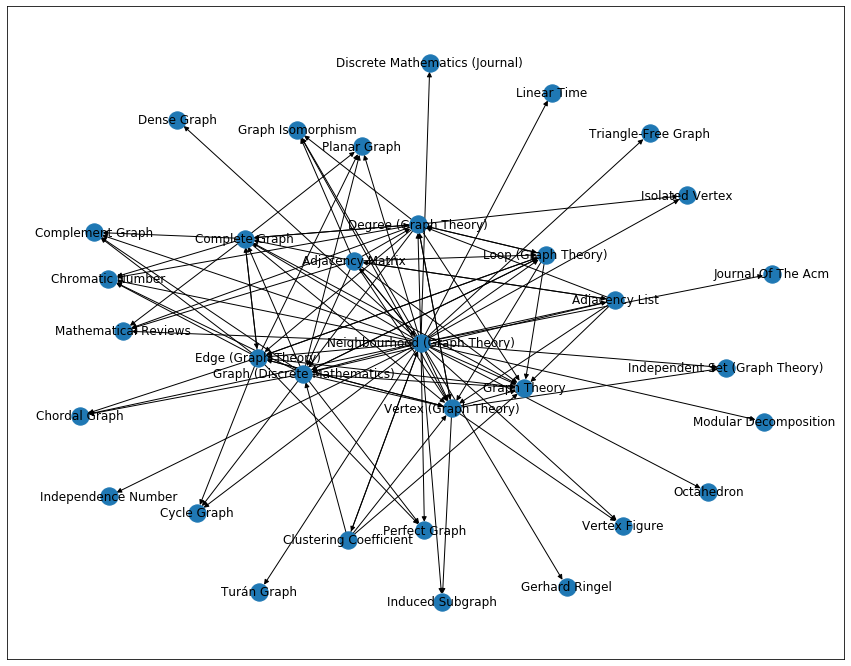

In [25]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
egonet = nx.ego_graph(G, ego)

_, plot = plt.subplots(figsize=(15,12))
pos = graphviz_layout(egonet)
nx.draw_networkx(egonet, pos)

plt.show()

### Clustering Coefficient

Function `nx.clustering(G, nodes=None)` calculates the clustering coefficient—a
measure of the prevalence of triangles in an egocentric network. The clustering
coefficient is the fraction of possible triangles that contain the ego node and
exist. This measure is undefined for directed graphs; you must coerce a
digraph to an undirected graph before calculating the clustering coefficient.
The following code fragment shows how to call the function:

In [26]:
cc = nx.clustering(nx.Graph(G), ego)
print(cc)

0.4712273641851107


#### coefficient of the whole network:
the fraction of all possible triangles that exist in the network which is known as transitivity, a measure of transitive closure.

In [31]:
trans = nx.transitivity(G)
print(trans)

0.05418684434050721


Source : Dmitry Zinoviev - Complex Network Analysis in Python